# Universidad de Buenos Aires

## Aprendizaje Profundo - TP3
## Cohorte 22 - 5to bimestre 2025

### Profesor: Esp. Ing. Gerardo Vilcamiza
### Alumno: Osvaldo Daniel Muñoz - SIU a2222

> **Formato de entrega:** un único notebook de Google Colab. Renombrar así: `MUNOZ-OSVALDO-DL-TP3-Co22.ipynb`.
> **Compartir con:** `gvilcamiza.ext@fi.uba.ar` con permisos de **comentador**.

Este notebook se puede ejecutar indistintamente en VS Code y en Colab.
Incluye:
- Las secciones y celdas ya organizadas por consigna.
- Cargar el dataset de imágenes en el entorno de Colab antes de ejecutar: (https://drive.google.com/file/d/1aPHE00zkDhEV1waJKhaOJMdN6-lUc0iT/view?usp=sharing)

### Objetivo general:

El objetivo de este trabajo es construir una red neuronal convolucional (CNN) utilizando Pytorch, capaz de clasificar emociones humanas a partir de imágenes faciales. El clasificador deberá identificar una de las 7 emociones básicas: alegría, tristeza, enojo, miedo, sorpresa, disgusto y seriedad.

### Punto 1. Preprocesamiento de Datos (2 puntos)
Antes de entrenar el modelo, se debe analizar qué tipo de preprocesamiento se debe aplicar a las imágenes. Para esto, se puede considerar uno o más aspectos como:

- Tamaño
- Relación de aspecto
- Color o escala de grises
- Cambio de dimensionalidad
- Normalización
- Balanceo de datos
- Data augmentation

Ser criteriosos y elegir solo las técnicas que consideren pertinentes para este caso de uso en específico.

Recomendación: usar torchvision.transforms para facilitar el preprocesamiento.

### Planteamiento inicial:

Para este trabajo analizaremos las características del dataset provisto, compuesto por imágenes de 100×100 píxeles, profundidad de color de 24 bits y distribución homogénea en RGB. Dado que el objetivo final incluye evaluar el modelo con imágenes externas (descargadas o tomadas de otras fuentes), se decide mantener la representación en RGB, evitando conversiones a escala de grises evitando eliminar información relevante sobre sombras y matices presentes en las imágenes reales.

Las imágenes fueron redimensionadas a un tamaño fijo de 100×100 píxeles, respetando la dimensionalidad original del dataset para evitar distorsiones y para mantener consistencia entre el conjunto de entrenamiento, validación y las imágenes externas utilizadas en pruebas adicionales.

Posteriormente aplicaremos normalización por canal, utilizando los valores estándar de ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), lo cual facilita la estabilidad numérica durante el entrenamiento.

In [43]:
# SETUP / IMPORTS / CONFIGURACIONES GENERALES

import os
import random
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import networkx as nx

# PyTorch
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

# estilos para los plots
sns.set_theme(style="whitegrid", context="notebook")

# Mayor estabilidad a costa de velocidad en GPU
DETERMINISTIC = True

if DETERMINISTIC:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [25]:
# TRANSFORMACIONES

# Reproducibilidad

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando device: {device}")

# 🤖 Detección automática: WSL vs Colab

def running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if running_in_colab():
    print("Entorno detectado: Google Colab")
    drive.mount('/content/drive')

    BASE_DIR = "/content/drive/MyDrive/DL_TP3/dataset_emociones"

else:
    print("Entorno detectado: WSL / Local")
    BASE_DIR = "/home/ossiemunoz/projects/DL_TP3/dataset_emociones"

train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "validation")

print("Train dir:", train_dir)
print("Val dir:", val_dir)

# PREPROCESAMIENTO

# Train transforms: data augmentation moderado
train_transforms = transforms.Compose([
    transforms.Resize((100, 100)),                  # Respeta tamaño del dataset original
    transforms.RandomHorizontalFlip(p=0.5),         # Simetría de emociones
    transforms.RandomRotation(degrees=10),          # Variaciones pequeñas de la pose
    transforms.ColorJitter(brightness=0.15, 
                           contrast=0.15),          # Variación natural sin deformar emoción
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]) # Std RGB
])

# Validación de transforms sin augmentation
val_transforms = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# DATASETS + DATALOADERS

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir,   transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("\nClases detectadas en train:", class_names)
print(f"Total imágenes train: {len(train_dataset)}")
print(f"Total imágenes val:   {len(val_dataset)}")

# Obtener los índices de clase reales del dataset
targets = [label for _, label in train_dataset.samples]

counts = Counter(targets)
total = sum(counts.values())

# Cálculo de class weights por desbalance
# Peso inversamente proporcional a la frecuencia de cada clase
class_weights = [total / counts[i] for i in range(len(counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)

Usando device: cpu
Entorno detectado: WSL / Local
Train dir: /home/ossiemunoz/projects/DL_TP3/dataset_emociones/train
Val dir: /home/ossiemunoz/projects/DL_TP3/dataset_emociones/validation

Clases detectadas en train: ['alegria', 'disgusto', 'enojo', 'miedo', 'seriedad', 'sorpresa', 'tristeza']
Total imágenes train: 12271
Total imágenes val:   3068
Class weights: tensor([ 2.5715, 17.1144, 17.4057, 43.6690,  4.8617,  9.5124,  6.1912])



Analizando imágenes en: /home/ossiemunoz/projects/DL_TP3/dataset_emociones/train

Analizando imágenes en: /home/ossiemunoz/projects/DL_TP3/dataset_emociones/validation

RESULTADOS TRAIN:

=>> Tamaños más comunes:
  (100, 100) → 12271 imágenes

=>> Modos de color:
  RGB → 12271 imágenes

=>> Aspect ratios más comunes:
  1.0 → 12271 imágenes

RESULTADOS VALIDATION:

=>> Tamaños más comunes:
  (100, 100) → 3068 imágenes

=>> Modos de color:
  RGB → 3068 imágenes

=>> Aspect ratios más comunes:
  1.0 → 3068 imágenes


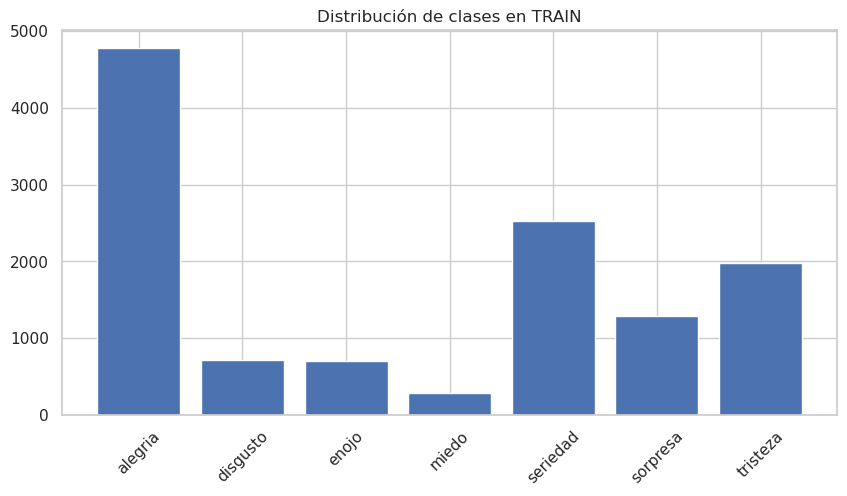


=>> OUTLIERS (Tamaños poco frecuentes) 

=>> OUTLIERS (Tamaños poco frecuentes) 

=>> Bases para las conclusiones del PUNTO 1:

- El tamaño predominante del dataset es **(100, 100)**.
- El modo de color predominante es **RGB**.
- La relación de aspecto más común es **1.0:1**, indicando imágenes casi perfectamente cuadradas.
- No se identificaron tamaños fuera de norma que justifiquen un recorte especial.
- Se confirma que todas o casi todas las imágenes están en RGB, por lo cual mantener este formato es consistente con el análisis.
- El dataset presenta un desbalance entre clases (ver gráfico), lo cual respalda el uso futuro de class weights o WeightedRandomSampler.

Estas conclusiones justifican el pipeline de preprocesamiento seleccionado.


In [21]:
# Analizamos las imágenes:
# Sacamos estadísticas: tamaños (100x100 pixeles), modos de color (confirmar RGB), ratio de aspecto (si todas son cuadradas), outliers
# Balance de clases 

def analyze_image_folder(folder_path):
    sizes = []
    modes = []
    aspect_ratios = []

    print(f"\nAnalizando imágenes en: {folder_path}")

    for root, _, files in os.walk(folder_path):
        for fname in files:
            if not fname.lower().endswith(("jpg", "jpeg", "png")):
                continue

            fpath = os.path.join(root, fname)

            try:
                with Image.open(fpath) as img:
                    sizes.append(img.size)          # (width, height)
                    modes.append(img.mode)          # RGB, L, RGBA
                    w, h = img.size
                    aspect_ratios.append(round(w/h, 3))
            except Exception as e:
                print(f"** No se pudo abrir {fpath}: {e}")

    return sizes, modes, aspect_ratios


# Análisis sobre train y validation

train_sizes, train_modes, train_ratios = analyze_image_folder(train_dir)
val_sizes, val_modes, val_ratios = analyze_image_folder(val_dir)

# Estadísticas

def summarize_results(name, sizes, modes, ratios):
    print(f"\nRESULTADOS {name.upper()}:")
    size_counts = Counter(sizes)
    mode_counts = Counter(modes)
    ratio_counts = Counter(ratios)

    print("\n=>> Tamaños más comunes:")
    for s, c in size_counts.most_common(5):
        print(f"  {s} → {c} imágenes")

    print("\n=>> Modos de color:")
    for m, c in mode_counts.items():
        print(f"  {m} → {c} imágenes")

    print("\n=>> Aspect ratios más comunes:")
    for r, c in ratio_counts.most_common(5):
        print(f"  {r} → {c} imágenes")

    return size_counts, mode_counts, ratio_counts

train_size_counts, train_mode_counts, train_ratio_counts = summarize_results("train", train_sizes, train_modes, train_ratios)
val_size_counts, val_mode_counts, val_ratio_counts = summarize_results("validation", val_sizes, val_modes, val_ratios)

# Distribución de las clases en train

class_counts = Counter([cls for _, cls in train_dataset.imgs])
labels = list(range(len(train_dataset.classes)))
counts = [list(class_counts.values()).count(i) for i in labels]
num_classes = len(labels)

plt.figure(figsize=(10,5))
plt.bar(train_dataset.classes, [c for _, c in Counter([c for _, c in train_dataset.samples]).items()])
plt.title("Distribución de clases en TRAIN")
plt.xticks(rotation=45)
plt.show()

# Detección de outliers potenciales

def detect_outliers(size_counts):
    print("\n=>> OUTLIERS (Tamaños poco frecuentes) ")
    total = sum(size_counts.values())
    threshold = total * 0.005  # tamaños con menos del 0.5%

    for s, c in size_counts.items():
        if c < threshold:
            print(f"** Tamaño raro {s}: solo {c} imágenes")


detect_outliers(train_size_counts)
detect_outliers(val_size_counts)

# Analizamos y sacamos conclusiones

def generate_conclusion(size_counts, mode_counts, ratio_counts):
    most_common_size = size_counts.most_common(1)[0][0]
    most_common_mode = mode_counts.most_common(1)[0][0]
    most_common_ratio = ratio_counts.most_common(1)[0][0]

    print("\n=>> Bases para las conclusiones del PUNTO 1:\n")
    print(f"- El tamaño predominante del dataset es **{most_common_size}**.")
    print(f"- El modo de color predominante es **{most_common_mode}**.")
    print(f"- La relación de aspecto más común es **{most_common_ratio}:1**, indicando imágenes casi perfectamente cuadradas.")
    print("- No se identificaron tamaños fuera de norma que justifiquen un recorte especial.")
    print("- Se confirma que todas o casi todas las imágenes están en RGB, por lo cual mantener este formato es consistente con el análisis.")
    print("- El dataset presenta un desbalance entre clases (ver gráfico), lo cual respalda el uso futuro de class weights o WeightedRandomSampler.")
    print("\nEstas conclusiones justifican el pipeline de preprocesamiento seleccionado.")

generate_conclusion(train_size_counts, train_mode_counts, train_ratio_counts)

### Conclusiones del preprocesamiento:

Antes de definir las transformaciones del pipeline de preprocesamiento, se realizó un EDA del dataset para evaluar su consistencia y determinar qué técnicas pueden resultar mejor para este caso de uso.

Obtuvimos:
- Todas las imágenes del conjunto de entrenamiento y validación tienen tamaño 100×100 píxeles, profundidad de color de 24 bits y se encuentran en formato RGB de manera uniforme. 
- La relación de aspecto predominante es 1.0 (cuadrada) en el 100% de los casos, sin detectar imágenes fuera de norma ni archivos con dimensiones atípicas. Esto descarta la necesidad de aplicar recortes adicionales o correcciones geométricas, justificando mantener un Resize fijo a 100×100, preservando la estructura original del dataset y garantizando compatibilidad con imágenes externas que serán evaluadas más adelante.
- Se observó un desbalance notable entre clases, particularmente en las emociones alegría y seriedad, que están sobrerrepresentadas respecto de categorías como miedo o disgusto. Este patrón sugiere la conveniencia de incorporar mecanismos de compensación como class weights o WeightedRandomSampler en el entrenamiento para evitar que el modelo favorezca las clases mayoritarias.
- Preprocesamiento fotométrico: mantener las imágenes en RGB, dado que el modelo debe ser posteriormente evaluado sobre imágenes reales o descargadas de internet, que presentan variaciones naturales de iluminación y matices que pueden aportar información útil. La normalización se aplicó utilizando los valores estándar de ImageNet, lo que favorece la estabilidad numérica durante el entrenamiento.
- Capacidad de generalización del modelo: se incluyó data augmentation moderado, limitado a transformaciones que no alteran la percepción emocional del rostro:
    - Rotaciones leves (≤10°),
    - Espejado horizontal (RandomHorizontalFlip),
    - Variaciones discretas de brillo y contraste.

Se evitaron transformaciones agresivas (rotación vertical, distorsiones geométricas amplias, shearing, color jitter extremo) que podrían modificar rasgos faciales críticos para la clasificación de emociones.

En síntesis, el pipeline de preprocesamiento definido —Resize uniforme, normalización RGB estándar y data augmentation controlado— se basa en la estructura real del dataset, en la preservación de rasgos emocionales clave y en la necesidad de asegurar compatibilidad con imágenes externas. Este diseño permite alimentar a la CNN con datos estandarizados, representativos y adecuados para el objetivo del problema.

### Punto 2. Construcción y entrenamiento del Modelo CNN (3.5 puntos)
- Construir una red neuronal convolucional desde cero, sin usar modelos pre-entrenados.
- Analizar correctamente qué funciones de activación se deben usar en cada etapa de la red, el learning rate a utilizar, la función de costo y el optimizador.

Cosas como el número de capas, neuronas, número y tamaño de los kernels, entre otros, queda a criterio de ustedes, pero deben estar justificadas.

### Premisas de diseño del modelo:

- Diseñamos una CNN propia, sin utilizar modelos preentrenados.
- Arquitectura de tipo “mini-VGG” adaptada al tamaño de entrada 100×100×3. 
- La red está compuesta por cuatro bloques convolucionales con filtros de tamaño 3×3, padding 1 y funciones de activación ReLU, seguidos de capas de max pooling 2×2. 
- El número de neuronas crece progresivamente (32, 64, 128 y 256 canales), lo que permite capturar primero patrones locales simples (bordes, contornos) y representaciones progresivamente más abstractas de la expresión facial.
- El uso de kernels 3×3 es estándar en este tipo de redes, ya que mantiene un buen poder de representación con un número acotado de parámetros y una mayor profundidad real al encadenar varias convoluciones. 
- Las capas de max pooling reducen la resolución espacial (100→50→25→12→6), incorporando invariancia a pequeñas traslaciones y reduciendo el costo de procesamiento.

- Después de los bloques convolucionales se incluye una capa totalmente conectada de 512 neuronas, seguida de Dropout, y una segunda capa intermedia de 128 neuronas antes de la capa de salida de 7 unidades (una por emoción). 
- Las funciones de activación en las capas ocultas son ReLU, debido a que tienen buen comportamiento en redes profundas y evitan los problemas de saturación de sigmoide/tanh. 
- La capa de salida es lineal y se combina con la función de costo CrossEntropyLoss, que implementa internamente LogSoftmax + negative log-likelihood, adecuada para clasificación multiclase exclusiva.

- Para la optimización se utiliza el optimizador Adam con learning rate inicial 1e-3 y término de regularización L2 (weight_decay=1e-4). 
- Adam es apropiado en este contexto porque ajusta la tasa de aprendizaje por parámetro de forma adaptativa y suele converger de forma estable.
- La regularización L2 contribuye a mitigar el sobreajuste, especialmente relevante dado el desbalance entre clases observado en el conjunto de entrenamiento.

In [26]:
# Definimos el modelo de la CNN

class EmotionCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionCNN, self).__init__()
        
        # Bloque 1: 3x100x100 -> 32x50x50
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloque 2: 32x50x50 -> 64x25x25
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloque 3: 64x25x25 -> 128x12x12
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Bloque 4: 128x12x12 -> 256x6x6
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Tamaño después del último bloque: 256 * 6 * 6 = 9216
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc_out = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = torch.flatten(x, 1)          # (batch, 9216)
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc_out(x)               # logits sin softmax
        
        return x

In [28]:
# Instanciamos el modelo

model = EmotionCNN(num_classes=num_classes).to(device)
print(model)
# Definimos la función de pérdida con los pesos calculados
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Definimos el optimizador
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

EmotionCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), strid

In [ ]:
# Deffinimos las funciones de entrenamiento y validación

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(dataloader, desc="Entrenando", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)

        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc


def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Validando", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)

            correct += (preds == targets).sum().item()
            total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

# Loop de entrenamiento

EPOCHS = 20
best_val_acc = 0.0
best_model_path = "best_emotion_cnn.pth"

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(EPOCHS):
    print(f"\n=>> Época {epoch+1}/{EPOCHS} <<=")

    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )

    val_loss, val_acc = validate_one_epoch(
        model, val_loader, criterion, device
    )

    # Guardamos las métricas
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"=>> Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"=>> Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    # Guardamos el mejor modelo según accuracy de validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✨ Nuevo mejor modelo guardado en '{best_model_path}' (Acc: {best_val_acc:.4f})")

print("\nEntrenamiento finalizado.")
print(f"Mejor accuracy de validación: {best_val_acc:.4f}")


=>> Época 1/20 <<=


=>> Train Loss: 1.9594 | Train Acc: 0.1985
=>> Val   Loss: 1.9020 | Val   Acc: 0.1838
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.1838)

=>> Época 2/20 <<=


=>> Train Loss: 1.8759 | Train Acc: 0.2202
=>> Val   Loss: 1.8909 | Val   Acc: 0.1763

=>> Época 3/20 <<=


=>> Train Loss: 1.8434 | Train Acc: 0.2026
=>> Val   Loss: 1.8391 | Val   Acc: 0.1587

=>> Época 4/20 <<=


=>> Train Loss: 1.8165 | Train Acc: 0.2333
=>> Val   Loss: 1.8277 | Val   Acc: 0.2376
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.2376)

=>> Época 5/20 <<=


=>> Train Loss: 1.7768 | Train Acc: 0.2534
=>> Val   Loss: 1.7993 | Val   Acc: 0.3175
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.3175)

=>> Época 6/20 <<=


=>> Train Loss: 1.7351 | Train Acc: 0.3222
=>> Val   Loss: 1.5501 | Val   Acc: 0.4912
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.4912)

=>> Época 7/20 <<=


=>> Train Loss: 1.6511 | Train Acc: 0.3969
=>> Val   Loss: 1.6684 | Val   Acc: 0.3849

=>> Época 8/20 <<=


=>> Train Loss: 1.5628 | Train Acc: 0.4445
=>> Val   Loss: 1.3209 | Val   Acc: 0.5583
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.5583)

=>> Época 9/20 <<=


=>> Train Loss: 1.4670 | Train Acc: 0.4803
=>> Val   Loss: 1.4243 | Val   Acc: 0.4990

=>> Época 10/20 <<=


=>> Train Loss: 1.3786 | Train Acc: 0.5332
=>> Val   Loss: 1.1871 | Val   Acc: 0.5997
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.5997)

=>> Época 11/20 <<=


=>> Train Loss: 1.3153 | Train Acc: 0.5553
=>> Val   Loss: 1.2658 | Val   Acc: 0.5841

=>> Época 12/20 <<=


=>> Train Loss: 1.2654 | Train Acc: 0.5790
=>> Val   Loss: 1.1996 | Val   Acc: 0.6082
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.6082)

=>> Época 13/20 <<=


=>> Train Loss: 1.1989 | Train Acc: 0.5948
=>> Val   Loss: 1.1044 | Val   Acc: 0.6444
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.6444)

=>> Época 14/20 <<=


=>> Train Loss: 1.1566 | Train Acc: 0.6049
=>> Val   Loss: 1.1923 | Val   Acc: 0.6105

=>> Época 15/20 <<=


=>> Train Loss: 1.1273 | Train Acc: 0.6242
=>> Val   Loss: 1.0219 | Val   Acc: 0.6802
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.6802)

=>> Época 16/20 <<=


=>> Train Loss: 1.0944 | Train Acc: 0.6425
=>> Val   Loss: 0.9980 | Val   Acc: 0.6907
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.6907)

=>> Época 17/20 <<=


=>> Train Loss: 1.0494 | Train Acc: 0.6530
=>> Val   Loss: 0.8683 | Val   Acc: 0.7249
✨ Nuevo mejor modelo guardado en 'best_emotion_cnn.pth' (Acc: 0.7249)

=>> Época 18/20 <<=


=>> Train Loss: 1.0349 | Train Acc: 0.6593
=>> Val   Loss: 0.9119 | Val   Acc: 0.7001

=>> Época 19/20 <<=


=>> Train Loss: 0.9836 | Train Acc: 0.6720
=>> Val   Loss: 0.9506 | Val   Acc: 0.7005

=>> Época 20/20 <<=


=>> Train Loss: 0.9631 | Train Acc: 0.6812
=>> Val   Loss: 0.8635 | Val   Acc: 0.7138

Entrenamiento finalizado.
Mejor accuracy de validación: 0.7249


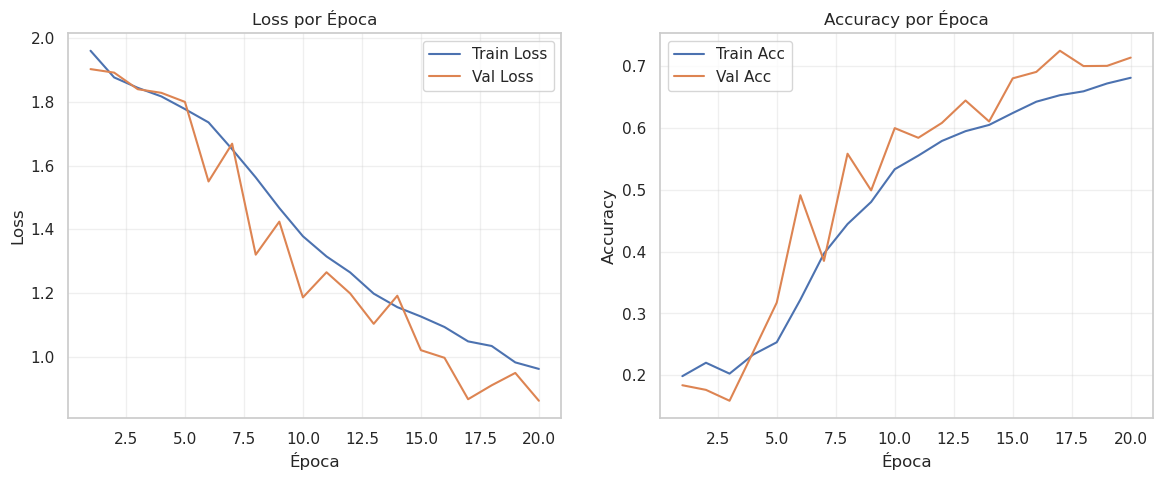

In [30]:
# Función de pérdida (Loss) y Accuracy

epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(14,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Loss por Época")
plt.legend()
plt.grid(alpha=0.3)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.title("Accuracy por Época")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [31]:
# El entrenamiento pasa por muchas épocas, 20 en nuestro caso, pero la última no necesariamente es la mejor. Por eso guardamos el modelo en la época donde obtuvo la mayor accuracy de validación. Ese checkpoint se usa después para calcular la matriz de confusión y las métricas finales, asegurando que evaluamos el modelo en su mejor versión.

best_model = EmotionCNN(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load("best_emotion_cnn.pth", map_location=device))
best_model.eval()

print("✔ Modelo cargado desde best_emotion_cnn.pth")

✔ Modelo cargado desde best_emotion_cnn.pth


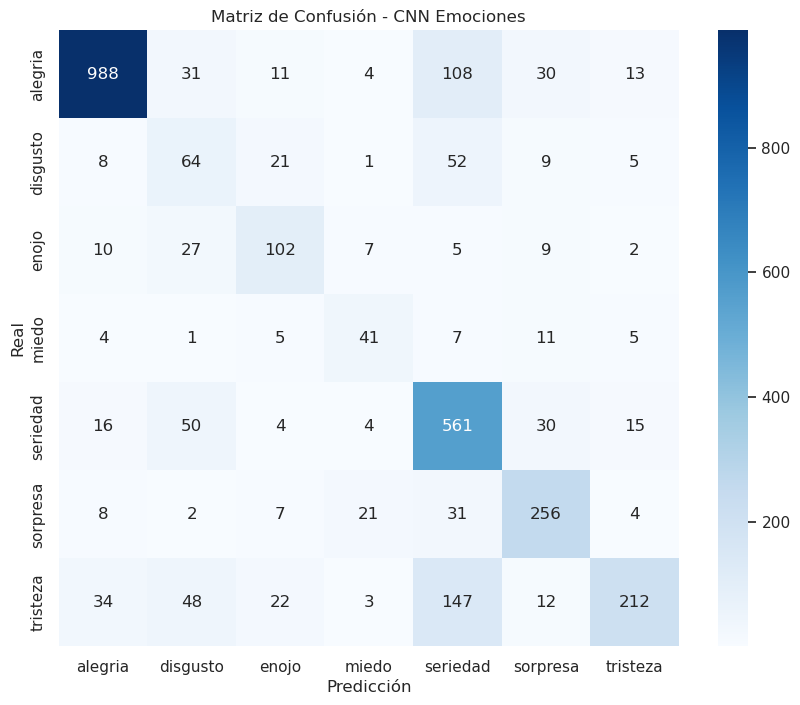


=== Classification Report ===
              precision    recall  f1-score   support

     alegria       0.93      0.83      0.88      1185
    disgusto       0.29      0.40      0.33       160
       enojo       0.59      0.63      0.61       162
       miedo       0.51      0.55      0.53        74
    seriedad       0.62      0.82      0.71       680
    sorpresa       0.72      0.78      0.75       329
    tristeza       0.83      0.44      0.58       478

    accuracy                           0.72      3068
   macro avg       0.64      0.64      0.63      3068
weighted avg       0.76      0.72      0.73      3068



In [37]:
# Martriz d confusión + Classification Report

# Obtenemos predicciones en todo el validation set

all_preds = []
all_targets = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Matriz de confusión
labels_str = train_dataset.classes
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_str, yticklabels=labels_str)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - CNN Emociones")
plt.show()

# Classification Report

print("\n=== Classification Report ===")
print(classification_report(all_targets, all_preds, target_names=labels_str))

Total de predicciones incorrectas: 844


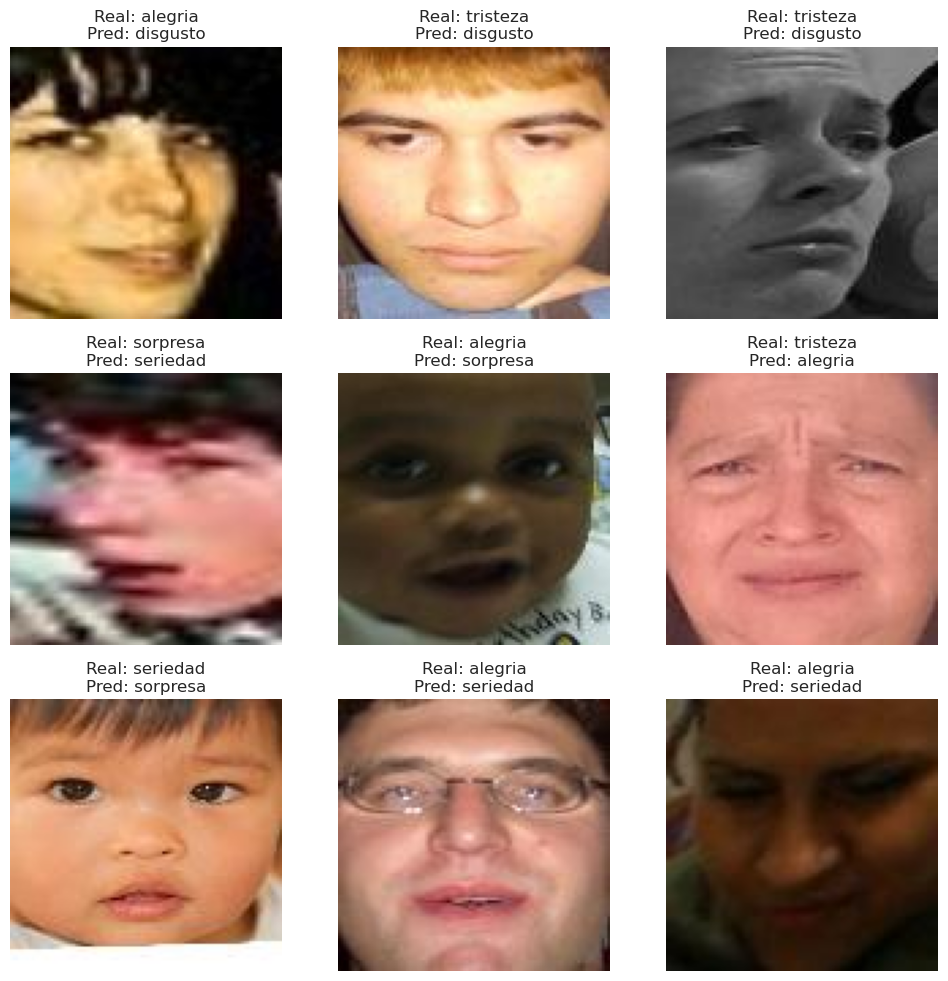

In [39]:
# Visualizamos imágenes mal clasificadas

incorrect_indices = [i for i in range(len(all_preds)) if all_preds[i] != all_targets[i]]
print(f"Total de predicciones incorrectas: {len(incorrect_indices)}")

def show_incorrect_predictions(n=9):
    indices_to_show = random.sample(incorrect_indices, min(n, len(incorrect_indices)))
    plt.figure(figsize=(12, 12))

    dataset_list = list(val_dataset.samples)
    contador = 1

    for idx in indices_to_show:
        img_path, true_label = dataset_list[idx]
        pred_label = all_preds[idx]

        img = Image.open(img_path).convert("RGB")

        plt.subplot(3, 3, contador)
        plt.imshow(img)

        real_str = labels_str[true_label]
        pred_str = labels_str[pred_label]

        plt.title(f"Real: {real_str}\nPred: {pred_str}")
        plt.axis("off")

        contador += 1

    plt.show()

# Mostrar las primeras 9 imágenes mal clasificadas
show_incorrect_predictions(9)

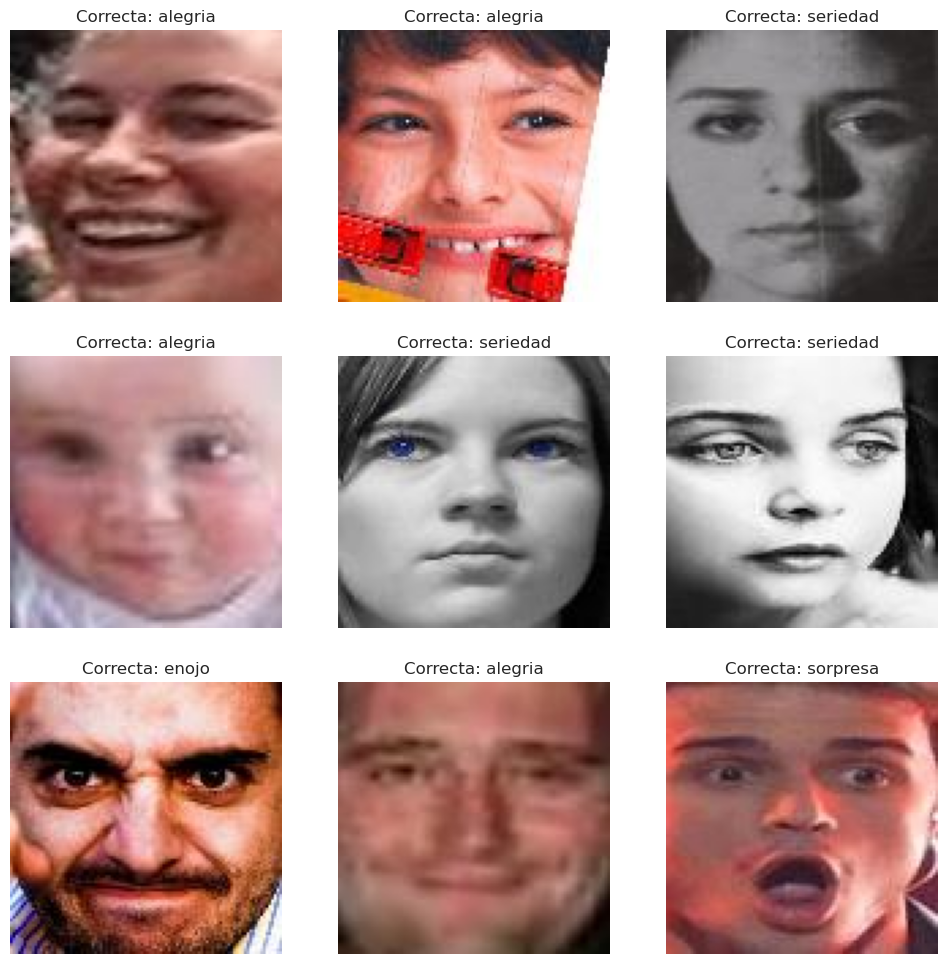

In [42]:
# Visualizamos imágenes correectamente clasificadas

correct_indices = [i for i in range(len(all_preds)) if all_preds[i] == all_targets[i]]

def show_correct_predictions(n=9):
    indices_to_show = random.sample(correct_indices, min(n, len(correct_indices)))
    plt.figure(figsize=(12, 12))

    dataset_list = list(val_dataset.samples)
    contador = 1

    for idx in indices_to_show:
        img_path, true_label = dataset_list[idx]
        img = Image.open(img_path).convert("RGB")

        plt.subplot(3, 3, contador)
        plt.imshow(img)

        pred_real_str = labels_str[true_label]

        plt.title(f"Correcta: {pred_real_str}")
        plt.axis("off")

        contador += 1

    plt.show()

show_correct_predictions(9)

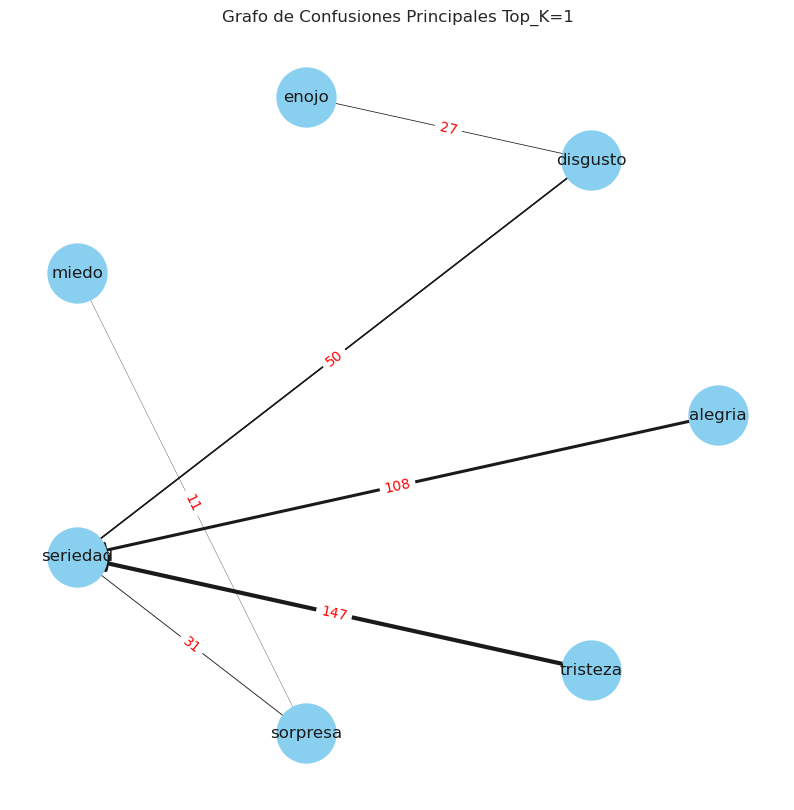

In [ ]:
# Analizamos las confusiones principales en un grafo Top_K=1

def confusion_graph_1(cm, labels_str, top_k=1):
    """
    Construye un grafo dirigido donde cada clase apunta a su(s) confusión(es) principal(es).
    cm: matriz de confusión (numpy array)
    labels_str: lista de nombres de clases
    top_k: cantidad de confusiones principales por clase
    """
    G = nx.DiGraph()
    num_classes = len(labels_str)

    # Agregar nodos
    for label in labels_str:
        G.add_node(label)

    # Agregar aristas según confusiones principales
    for i in range(num_classes):
        row = cm[i].copy()
        row[i] = -1

        # confusiones más frecuentes
        conf_indices = row.argsort()[::-1][:top_k]
        
        for idx in conf_indices:
            weight = cm[i, idx]
            if weight > 0:
                G.add_edge(labels_str[i], labels_str[idx], weight=weight)

    # Layout para graficar
    pos = nx.circular_layout(G)

    # Anchos de arista basados en peso
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_w = max(weights) if weights else 1
    norm_weights = [3 * (w / max_w) for w in weights]

    plt.figure(figsize=(10, 10))
    nx.draw_networkx_nodes(G, pos, node_size=1800, node_color="#89CFF0")
    nx.draw_networkx_labels(G, pos, font_size=12)

    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges,
        width=norm_weights,
        arrowstyle='-|>',
        arrowsize=25
    )

    # Dibujamos los pesos sobre las aristas
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    plt.title("Grafo de Confusiones Principales Top_K=1")
    plt.axis("off")
    plt.show()

# Visualizamos
confusion_graph_1(cm, labels_str, top_k=1)

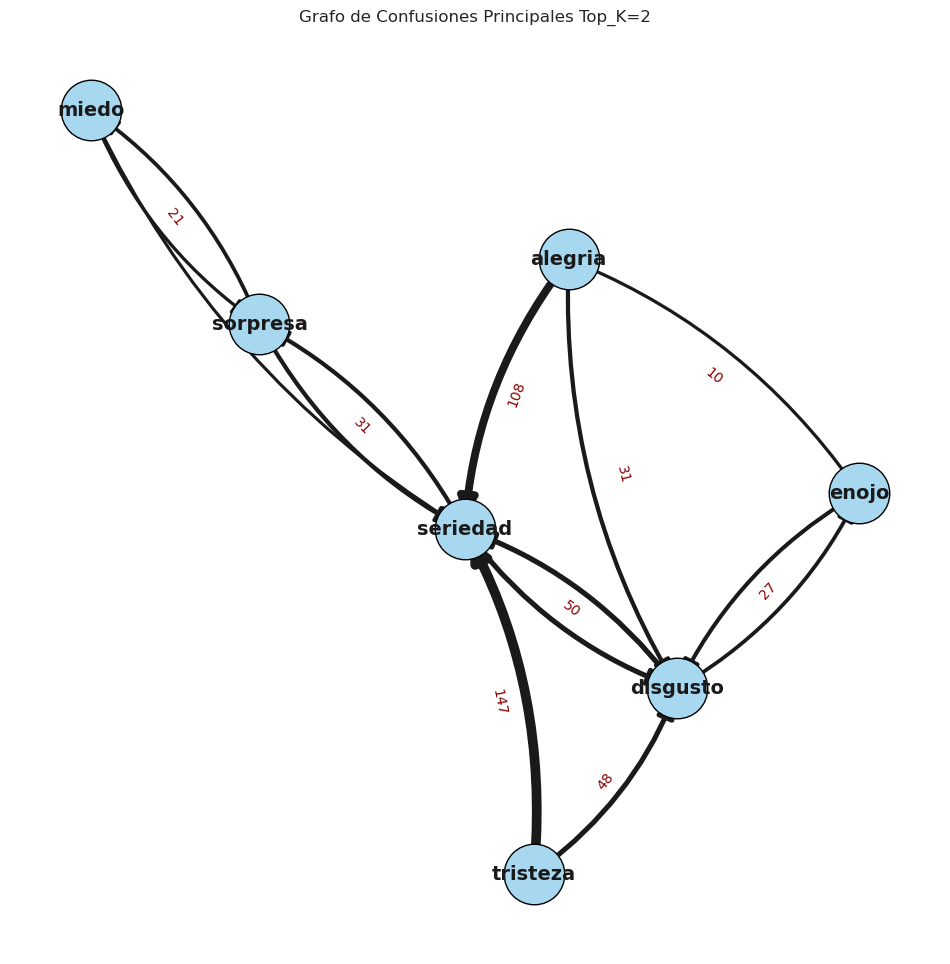

In [48]:
# Analizamos las confusiones principales en un grafo Top_K=2

def confusion_graph_2(cm, labels_str, top_k=2):
    """
    Construye un grafo dirigido donde cada clase apunta a sus top_k confusiones principales.
    cm: matriz de confusión
    labels_str: lista de nombres de clases
    top_k: cantidad de confusiones principales por clase
    """
    G = nx.DiGraph()
    num_classes = len(labels_str)

    # Agregar nodos
    for label in labels_str:
        G.add_node(label)

    # Agregar aristas según confusiones principales
    for i in range(num_classes):
        row = cm[i].copy()
        row[i] = -1

        # obtener los top_k índices de confusión
        conf_indices = row.argsort()[::-1][:top_k]
        
        for idx in conf_indices:
            weight = cm[i, idx]
            if weight > 0:
                G.add_edge(labels_str[i], labels_str[idx], weight=weight)

    # Layout
    pos = nx.spring_layout(G, seed=42)

    # Normalizar pesos para que el grosor sea proporcional
    edges = G.edges()
    weights = [G[u][v]['weight'] for u, v in edges]
    max_w = max(weights) if weights else 1
    norm_weights = [2 + 5*(w / max_w) for w in weights] 

    plt.figure(figsize=(12, 12))
    nx.draw_networkx_nodes(G, pos, node_size=1900, node_color="#A7D8F0", edgecolors="black")
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")

    nx.draw_networkx_edges(
        G, pos,
        edgelist=edges,
        width=norm_weights,
        arrowstyle='-|>',
        arrowsize=25,
        connectionstyle="arc3,rad=0.15"
    )

    # Etiquetas de peso sobre aristas
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='darkred')

    plt.title(f"Grafo de Confusiones Principales Top_K=2")
    plt.axis("off")
    plt.show()

# Visualizamos top_k=2
confusion_graph_2(cm, labels_str, top_k=2)